IMPORTING ALL LIBRARIES

In [1]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.datasets import mnist
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

PRE-PROCESSING THE DATASET

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255
X_test = X_test / 255

# reshape
width = X_train.shape[1]
height = X_test.shape[2]
channels = 1

X_train = X_train.reshape(X_train.shape[0], height, width, channels)
X_test = X_test.reshape(X_test.shape[0], height, width, channels)
input_shape = (height, width, channels)

print(X_train.shape, X_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (10000, 28, 28, 1)


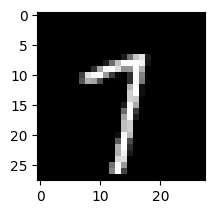

In [3]:
# peeking
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[42][:,:,0], cmap="gray")


CREATE THE MODEL

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_1[0][0]']            
                                                                                                

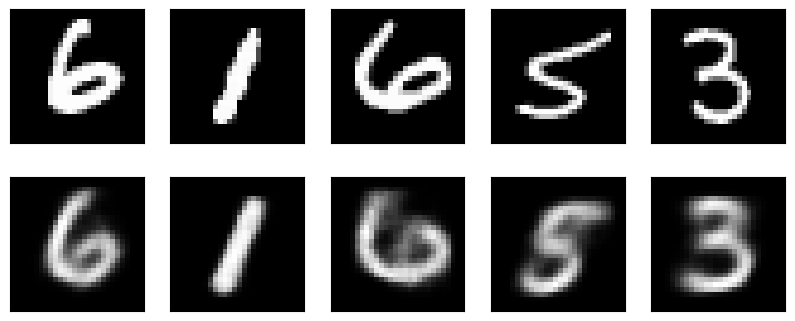

In [4]:
latent_dim = 2 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')

# apply the decoder to the latent sample
z_decoded = decoder(z)

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss (BCE)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # Mean Squared Error (MSE) for reconstruction
        mse_loss = keras.losses.mean_squared_error(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        # Print the MSE during training
        self.add_metric(mse_loss, name='mse_loss', aggregation='mean')

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(X_train, None, epochs=10, batch_size=32, validation_split=0.2)

# Select 5 random images from X_test
indices = np.random.choice(len(X_test), 5)

# Create a big plot
plt.figure(figsize=(10, 4))

for i, index in enumerate(indices):
    # Select the image
    original_image = X_test[index]

    # Reshape the original image to match the input shape of the encoder
    original_image_reshaped = original_image.reshape(1, 28, 28, 1)

    # Encode the original image to get the latent vector
    z_mu, z_sigma, z = encoder.predict(original_image_reshaped)

    # Decode the latent sample to get the reconstructed image
    decoded_image = decoder.predict(z)
    decoded_image_reshaped = decoded_image.reshape(28, 28)

    # Plot the original image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot the reconstructed image
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_image_reshaped, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_5 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 14, 14, 64)           36928     ['conv2d_5[0][0]']            
                                                                                                

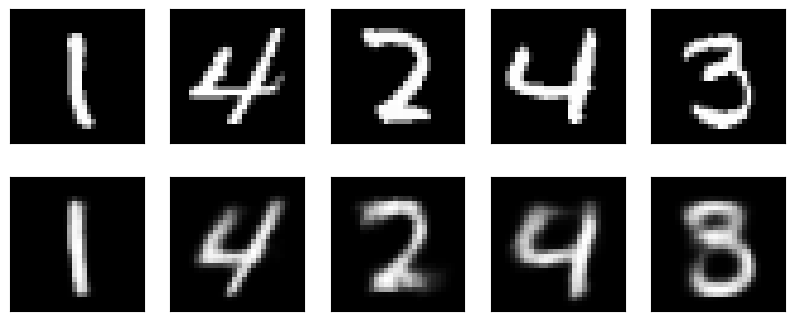

In [5]:
latent_dim = 4 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')

# apply the decoder to the latent sample
z_decoded = decoder(z)

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss (BCE)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # Mean Squared Error (MSE) for reconstruction
        mse_loss = keras.losses.mean_squared_error(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        # Print the MSE during training
        self.add_metric(mse_loss, name='mse_loss', aggregation='mean')

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(X_train, None, epochs=10, batch_size=32, validation_split=0.2)

# Select 5 random images from X_test
indices = np.random.choice(len(X_test), 5)

# Create a big plot
plt.figure(figsize=(10, 4))

for i, index in enumerate(indices):
    # Select the image
    original_image = X_test[index]

    # Reshape the original image to match the input shape of the encoder
    original_image_reshaped = original_image.reshape(1, 28, 28, 1)

    # Encode the original image to get the latent vector
    z_mu, z_sigma, z = encoder.predict(original_image_reshaped)

    # Decode the latent sample to get the reconstructed image
    decoded_image = decoder.predict(z)
    decoded_image_reshaped = decoded_image.reshape(28, 28)

    # Plot the original image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot the reconstructed image
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_image_reshaped, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_9 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_9[0][0]']            
                                                                                                

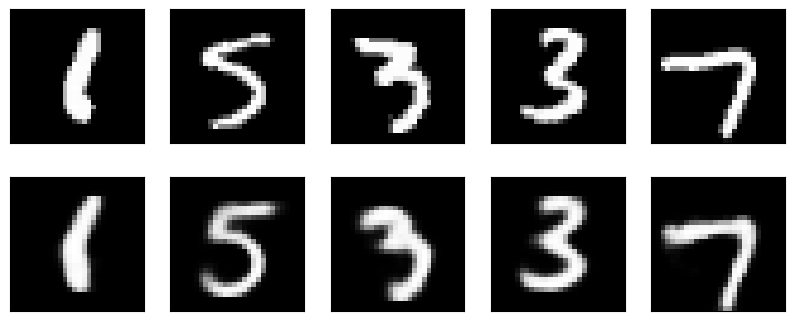

In [6]:
latent_dim = 8 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')

# apply the decoder to the latent sample
z_decoded = decoder(z)

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss (BCE)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # Mean Squared Error (MSE) for reconstruction
        mse_loss = keras.losses.mean_squared_error(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        # Print the MSE during training
        self.add_metric(mse_loss, name='mse_loss', aggregation='mean')

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(X_train, None, epochs=10, batch_size=32, validation_split=0.2)

# Select 5 random images from X_test
indices = np.random.choice(len(X_test), 5)

# Create a big plot
plt.figure(figsize=(10, 4))

for i, index in enumerate(indices):
    # Select the image
    original_image = X_test[index]

    # Reshape the original image to match the input shape of the encoder
    original_image_reshaped = original_image.reshape(1, 28, 28, 1)

    # Encode the original image to get the latent vector
    z_mu, z_sigma, z = encoder.predict(original_image_reshaped)

    # Decode the latent sample to get the reconstructed image
    decoded_image = decoder.predict(z)
    decoded_image_reshaped = decoded_image.reshape(28, 28)

    # Plot the original image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot the reconstructed image
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_image_reshaped, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_13 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_12[0][0]']           
                                                                                                  
 conv2d_14 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_13[0][0]']           
                                                                                                

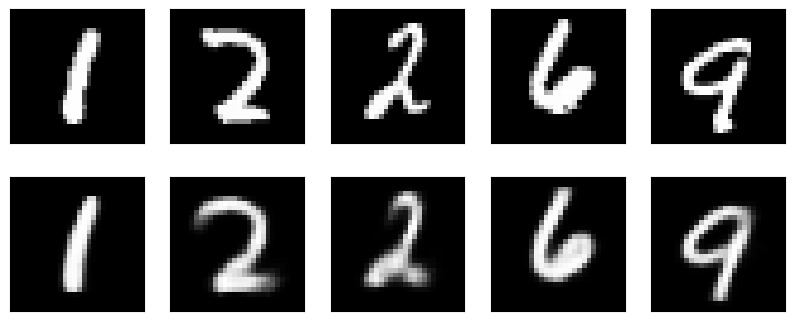

In [7]:
latent_dim = 16 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')

# apply the decoder to the latent sample
z_decoded = decoder(z)

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss (BCE)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # Mean Squared Error (MSE) for reconstruction
        mse_loss = keras.losses.mean_squared_error(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        # Print the MSE during training
        self.add_metric(mse_loss, name='mse_loss', aggregation='mean')

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(X_train, None, epochs=10, batch_size=32, validation_split=0.2)

# Select 5 random images from X_test
indices = np.random.choice(len(X_test), 5)

# Create a big plot
plt.figure(figsize=(10, 4))

for i, index in enumerate(indices):
    # Select the image
    original_image = X_test[index]

    # Reshape the original image to match the input shape of the encoder
    original_image_reshaped = original_image.reshape(1, 28, 28, 1)

    # Encode the original image to get the latent vector
    z_mu, z_sigma, z = encoder.predict(original_image_reshaped)

    # Decode the latent sample to get the reconstructed image
    decoded_image = decoder.predict(z)
    decoded_image_reshaped = decoded_image.reshape(28, 28)

    # Plot the original image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot the reconstructed image
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_image_reshaped, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_16 (Conv2D)          (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_17 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_16[0][0]']           
                                                                                                  
 conv2d_18 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_17[0][0]']           
                                                                                                

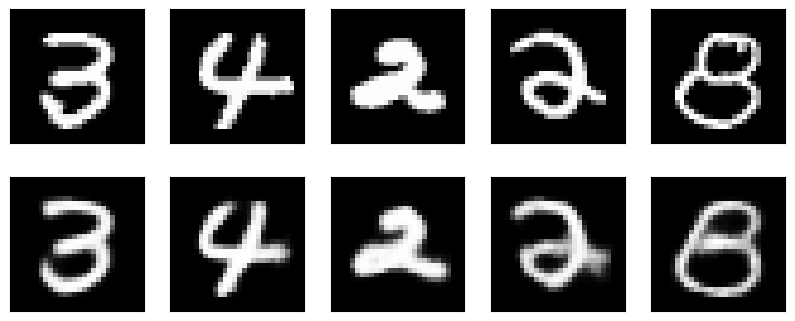

In [8]:
latent_dim = 32 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')

# apply the decoder to the latent sample
z_decoded = decoder(z)

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss (BCE)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # Mean Squared Error (MSE) for reconstruction
        mse_loss = keras.losses.mean_squared_error(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        # Print the MSE during training
        self.add_metric(mse_loss, name='mse_loss', aggregation='mean')

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(X_train, None, epochs=10, batch_size=32, validation_split=0.2)

# Select 5 random images from X_test
indices = np.random.choice(len(X_test), 5)

# Create a big plot
plt.figure(figsize=(10, 4))

for i, index in enumerate(indices):
    # Select the image
    original_image = X_test[index]

    # Reshape the original image to match the input shape of the encoder
    original_image_reshaped = original_image.reshape(1, 28, 28, 1)

    # Encode the original image to get the latent vector
    z_mu, z_sigma, z = encoder.predict(original_image_reshaped)

    # Decode the latent sample to get the reconstructed image
    decoded_image = decoder.predict(z)
    decoded_image_reshaped = decoded_image.reshape(28, 28)

    # Plot the original image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot the reconstructed image
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_image_reshaped, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 conv2d_21 (Conv2D)          (None, 14, 14, 64)           18496     ['conv2d_20[0][0]']           
                                                                                                  
 conv2d_22 (Conv2D)          (None, 14, 14, 64)           36928     ['conv2d_21[0][0]']           
                                                                                                

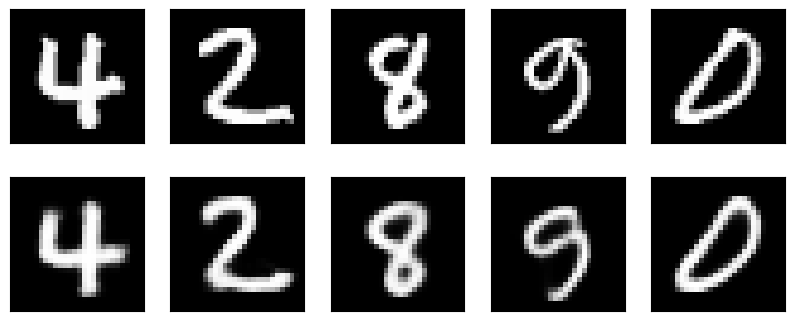

In [9]:
latent_dim = 64 # Number of latent dim parameters

input_img = Input(shape=input_shape, name='encoder_input')
x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)

conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

z_mu = Dense(latent_dim, name='latent_mu')(x)
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  

def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')

# apply the decoder to the latent sample
z_decoded = decoder(z)

class CustomLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)

        # Reconstruction loss (BCE)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)

        # Mean Squared Error (MSE) for reconstruction
        mse_loss = keras.losses.mean_squared_error(x, z_decoded)

        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)

        # Print the MSE during training
        self.add_metric(mse_loss, name='mse_loss', aggregation='mean')

        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])

vae = Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()
vae.fit(X_train, None, epochs=10, batch_size=32, validation_split=0.2)

# Select 5 random images from X_test
indices = np.random.choice(len(X_test), 5)

# Create a big plot
plt.figure(figsize=(10, 4))

for i, index in enumerate(indices):
    # Select the image
    original_image = X_test[index]

    # Reshape the original image to match the input shape of the encoder
    original_image_reshaped = original_image.reshape(1, 28, 28, 1)

    # Encode the original image to get the latent vector
    z_mu, z_sigma, z = encoder.predict(original_image_reshaped)

    # Decode the latent sample to get the reconstructed image
    decoded_image = decoder.predict(z)
    decoded_image_reshaped = decoded_image.reshape(28, 28)

    # Plot the original image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(original_image.reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot the reconstructed image
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded_image_reshaped, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()